In [1]:
import numpy as np
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import gensim
from nltk.corpus import brown
import random
from sklearn.model_selection import KFold

import gc

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks.callbacks import EarlyStopping
from scipy.stats import spearmanr
from nltk.corpus import wordnet as wn
#import tqdm
from sklearn.model_selection import StratifiedKFold
import sklearn.model_selection as ms
from sklearn import svm
import sklearn.naive_bayes as nb

import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

from wordcloud import WordCloud, STOPWORDS

import json

Using TensorFlow backend.


In [2]:
zf = zipfile.ZipFile('wine-reviews.zip') 
#dataset = pd.read_csv(zf.open('winemag-data-130k-v2.csv'))
description = json.load(zf.open('winemag-data-130k-v2.json'))

In [3]:
dataset = pd.DataFrame(description)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
country                  129908 non-null object
description              129971 non-null object
designation              92506 non-null object
points                   129971 non-null object
price                    120975 non-null float64
province                 129908 non-null object
region_1                 108724 non-null object
region_2                 50511 non-null object
taster_name              103727 non-null object
taster_twitter_handle    98758 non-null object
title                    129971 non-null object
variety                  129970 non-null object
winery                   129971 non-null object
dtypes: float64(1), object(12)
memory usage: 12.9+ MB


In [4]:
dataset["points"] = dataset.points.astype(float)

In [5]:
# Converting Points to Classes 

def points_to_class(points):
    if points in range(80,86):
        return 0
    elif points in range(86,91):
        return 1
    elif points in range(91,96):
        return 2
    else:
        return 3
  
    
dataset["rating"] = dataset["points"].apply(points_to_class)


""" Ratings are unbalanced """

dataset["rating"].value_counts()

1    74376
2    32754
0    21960
3      881
Name: rating, dtype: int64

In [7]:
dataset.describe()

,points,price,rating
count,129971.000000,120975.000000,129971.000000
mean,88.447138,35.363389,1.096606
std,3.039730,41.022218,0.662386
min,80.000000,4.000000,0.000000
25%,86.000000,17.000000,1.000000
50%,88.000000,25.000000,1.000000
75%,91.000000,42.000000,2.000000
max,100.000000,3300.000000,3.000000


In [8]:
dataset.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
rating                       0
dtype: int64

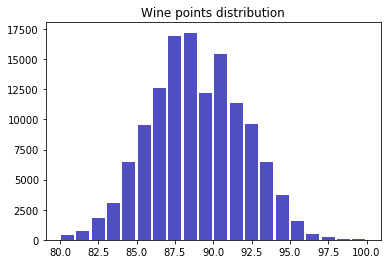

In [6]:
plt.hist(dataset['points'],bins=20,color='#0504aa',alpha=0.7, rwidth=0.85)
plt.title("Wine points distribution")
plt.show()

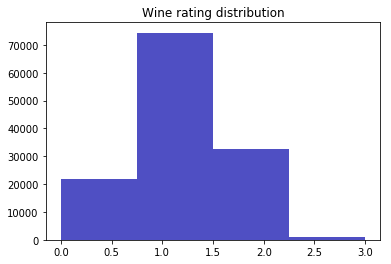

In [7]:
plt.hist(dataset['rating'],bins=4,color='#0504aa',alpha=0.7, rwidth=2)
plt.title("Wine rating distribution")
plt.show()

In [11]:
pd.options.display.max_colwidth = 500
print(dataset['description'][:5])

0                                                                                 Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.
1                          This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
2                                                                   Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.
3                                                      Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringe

## Cleaning description

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt
import nltk 
nltk.download('punkt')
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
ps = PorterStemmer()



[nltk_data] Downloading package punkt to /home/yang_jing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# set seaborn style 
sns.set(style="whitegrid")

stopwords = set(stopwords.words('english'))
detokenizer = TreebankWordDetokenizer()

def clean_description(desc):
    
    desc = word_tokenize(desc.lower())
    desc = [token for token in desc if token not in stopwords and token.isalpha()]
    #desc = [token for token in desc.replace("\n"," ").replace(","," , ").replace("("," ( ").replace(")"," ) ").
    #        replace("."," . ").replace("?"," ? ").replace(":"," : ").replace("n't"," not").
    #        replace("'ve"," have").replace("'re"," are").replace("'s"," is").split(" ") if token != ""]
    desc = [ps.stem(word) for word in desc]
    return detokenizer.detokenize(desc)

dataset["cleaned_description"] = dataset["description"].apply(clean_description)



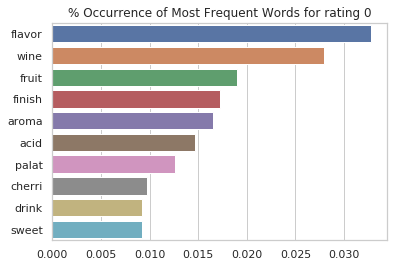

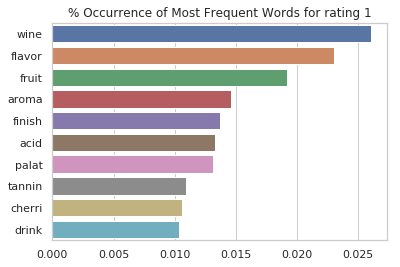

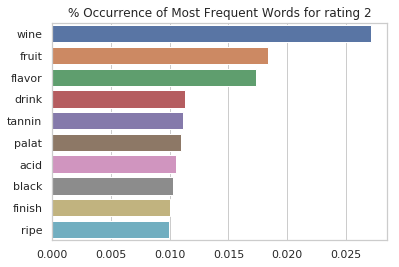

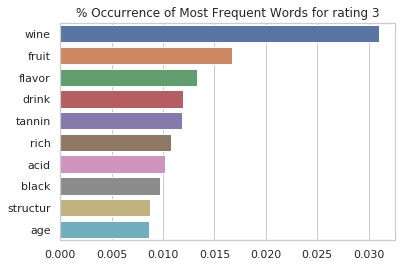

In [8]:
word_occurrence=[]
top_words=[]
for i in range(0,4):
    word_occurrence.append(dataset["cleaned_description"][dataset["rating"]==i].str.split(expand=True).stack().value_counts())
    total_words = sum(word_occurrence[i])
    top_words.append(word_occurrence[i][:10]/total_words)

    ax = sns.barplot(x = top_words[i].values, y = top_words[i].index)

    # Setting title 
    ax.set_title("% Occurrence of Most Frequent Words for rating " + str(i))

    plt.show()

In [9]:

#check train, test, and sample size
seed = 10
X_train, X_test, y_train, y_test = ms.train_test_split(dataset['cleaned_description'], dataset['rating'], test_size=0.5,random_state=seed)
#X_train=dataset['cleaned_description'][:2000]
#X_test=dataset['cleaned_description'][2000:2500]
#y_train=dataset['rating'][:2000]
#y_test=dataset['rating'][2000:2500]

print(len(X_train), len(X_test), len(y_train),len(y_test))

(64985, 64986, 64985, 64986)


## CountVectorizer

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
X_train_new = vectorizer.transform(X_train)
X_test_new=vectorizer.transform(X_test)
print('Shape of Sparse Matrix: ', X_train_new.shape)
print('Amount of Non-Zero occurrences: ', X_train_new.nnz)
# Percentage of non-zero values
density = (100.0 * X_train_new.nnz / (X_train_new.shape[0] * X_train_new.shape[1]))
print('Density: {}'.format((density)))

('Shape of Sparse Matrix: ', (64985, 16705))
('Amount of Non-Zero occurrences: ', 1500717)
Density: 0.138241742384


## Random forest

In [12]:
# Training the model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
rfc = RandomForestClassifier()
rfc.fit(X_train_new, y_train)

# Testing the model
predictions = rfc.predict(X_test_new)
print(classification_report(y_test, predictions))

/home/yang_jing/.local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.65      0.43      0.52     11021
           1       0.65      0.89      0.75     37170
           2       0.71      0.30      0.42     16351
           3       0.50      0.00      0.00       444

   micro avg       0.66      0.66      0.66     64986
   macro avg       0.63      0.40      0.42     64986
weighted avg       0.67      0.66      0.62     64986



In [35]:
print(rfc.score(X_test_new, y_test))
confusion_matrix(predictions,y_test)

0.6554642538392884


array([[ 4799,  2501,   165,     1],
       [ 6168, 32914, 11304,   186],
       [   54,  1755,  4882,   256],
       [    0,     0,     0,     1]])

## Naive Bayes with Countvectorizer

In [13]:

from sklearn.preprocessing import MaxAbsScaler
#Scale data
scaler = MaxAbsScaler()  # Default behavior is to scale to [0,1]
scaled_train = scaler.fit_transform(X_train_new)
scaled_test = scaler.transform(X_test_new)

In [37]:
# Use GridSearchCV to find optimal alpha
nb_model = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha': np.logspace(-2., 2., 50)})
nb_model.fit(X_train_new, y_train)
nb_model.score(X_test_new, y_test)

/home/yang_jing/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.704243991013449

In [38]:
# Testing the model
predictions = rfc.predict(X_test_new)
print(classification_report(y_test, predictions))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.64      0.44      0.52     11021
           1       0.65      0.89      0.75     37170
           2       0.70      0.30      0.42     16351
           3       1.00      0.00      0.00       444

   micro avg       0.66      0.66      0.66     64986
   macro avg       0.75      0.41      0.42     64986
weighted avg       0.66      0.66      0.62     64986

[[ 4799  2501   165     1]
 [ 6168 32914 11304   186]
 [   54  1755  4882   256]
 [    0     0     0     1]]


## SVM with Countvectorizer

In [16]:
#svm_model = ms.GridSearchCV(svm.SVC(kernel='rbf',cache_size=7000), 
 #                           {'C': [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1]}, 
  #                          cv=5)

svm_model = svm.LinearSVC()
svm_model.fit(scaled_train, y_train)
svm_model.score(scaled_test, y_test)

0.7086449389099191

In [17]:
# Testing the model
predictions = rfc.predict(scaled_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(predictions,y_test))

              precision    recall  f1-score   support

           0       0.18      0.97      0.31     11021
           1       0.50      0.09      0.15     37170
           2       0.81      0.00      0.00     16351
           3       0.00      0.00      0.00       444

   micro avg       0.21      0.21      0.21     64986
   macro avg       0.37      0.26      0.11     64986
weighted avg       0.52      0.21      0.14     64986

[[10718 33951 13503   323]
 [  303  3218  2835   119]
 [    0     1    13     2]
 [    0     0     0     0]]


/home/yang_jing/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## TF-IDF Vectorizer

In [13]:
def simple_prepro_tfidf(s):
    return " ".join([w for w in s.lower().replace("\n"," ").replace(","," , ").replace("("," ( ").replace(")"," ) ").
            replace("."," . ").replace("?"," ? ").replace(":"," : ").replace("n't"," not").
            replace("'ve"," have").replace("'re"," are").replace("'s"," is").split(" ") if w != ""])

In [25]:
# Vectorizing model
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1, 3))
tsvd = TruncatedSVD(n_components = 50)

X_train_tfidf = vectorizer_tfidf.fit_transform([simple_prepro_tfidf(s) for s in X_train])
print(X_train_tfidf.shape)
X_train_tfidf = tsvd.fit_transform(X_train_tfidf)
print(X_train_tfidf.shape)

X_test_tfidf=vectorizer_tfidf.transform(X_test)
X_test_tfidf = tsvd.transform(X_test_tfidf)

(64985, 1448040)
(64985, 50)


In [20]:
scaled_train_tfidf = scaler.fit_transform(X_train_tfidf)
scaled_test_tfidf = scaler.transform(X_test_tfidf)

In [21]:
rfc = RandomForestClassifier()
rfc.fit(scaled_train_tfidf, y_train)

# Testing model
predictions = rfc.predict(scaled_test_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.53      0.33      0.41     11021
           1       0.64      0.82      0.72     37170
           2       0.56      0.36      0.44     16351
           3       0.33      0.00      0.00       444

   micro avg       0.61      0.61      0.61     64986
   macro avg       0.52      0.38      0.39     64986
weighted avg       0.60      0.61      0.59     64986



In [22]:
rfc.score(scaled_test_tfidf, y_test)

0.6136090850336996

In [23]:
# Use GridSearchCV to find optimal alpha
nb_model_tfidf = ms.GridSearchCV(nb.BernoulliNB(), param_grid={'alpha': np.logspace(-2., 2., 50)})
nb_model_tfidf.fit(scaled_train_tfidf, y_train)
nb_model_tfidf.score(scaled_test_tfidf, y_test)

/home/yang_jing/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2052: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.6163635244514203

In [24]:
predictions = nb_model_tfidf.predict(scaled_test_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.25      0.35     11021
           1       0.62      0.87      0.73     37170
           2       0.59      0.30      0.39     16351
           3       0.00      0.00      0.00       444

   micro avg       0.62      0.62      0.62     64986
   macro avg       0.45      0.35      0.37     64986
weighted avg       0.61      0.62      0.57     64986



In [25]:
svm_model_tfidf = svm.LinearSVC()
                           
svm_model_tfidf.fit(scaled_train_tfidf, y_train)
svm_model_tfidf.score(scaled_test_tfidf, y_test)

0.641384298156526

In [26]:
predictions = nb_model_tfidf.predict(scaled_test_tfidf)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.59      0.25      0.35     11021
           1       0.62      0.87      0.73     37170
           2       0.59      0.30      0.39     16351
           3       0.00      0.00      0.00       444

   micro avg       0.62      0.62      0.62     64986
   macro avg       0.45      0.35      0.37     64986
weighted avg       0.61      0.62      0.57     64986



## GloVe

In [10]:
# Fixed parameters

num_classes = 4
embedding_dim = 100 
epochs = 5
batch_size = 32
max_len = 100
alpha = 0.1

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


In [11]:
class_weights

array([ 1.48516775,  0.43665672,  0.99044382, 37.17677346])

In [12]:
from keras.models import Model, load_model
from keras.layers import Dense, Embedding, Input, Activation, Bidirectional, Dropout, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

In [13]:
# train tokenizer (only on training set)
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(X_train)

vocab_size = tokenizer.word_index

# fit tokenizer on training set
sequences_train = tokenizer.texts_to_sequences(X_train)
print(sequences_train[0])

padded_train = pad_sequences(sequences_train, maxlen=max_len)
print(padded_train[0])

# fit tokenizer on testing set
sequences_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(sequences_test, maxlen = max_len)

# create embedding layer 
# We can stipulate Out of Vocabulary word vectors here 
# In this case, they are initialized to zero vector
embedding_matrix = np.zeros((len(vocab_size) + 1, embedding_dim))

print(embedding_matrix.shape)

[1, 36, 137, 13, 68, 8, 422, 157, 1, 142, 1, 335, 9]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  36 137
  13  68   8 422 157   1 142   1 335   9]
(16721, 100)


In [14]:
#importing the glove library
#import glove.Corpus 
from glove import Corpus, Glove

In [15]:
#X_train=X_train.tolist()
#X_train = X_train.tolist()

#new_X_train = X_train.split(' ')
new_X_train=[]
for line in X_train:
    new_X_train.append(line.split(' '))
    
new_X_test=[]
for line in X_test:
    new_X_test.append(line.split(' '))

In [16]:

# creating a corpus object
corpus = Corpus() 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(new_X_train, window=10)
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=100, learning_rate=0.01)
 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
#glove.save('glove_model')


Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [17]:
embedding_matrix.shape

(16721, 100)

In [17]:
for word, i in tokenizer.word_index.items():
    embedding_vector = glove.word_vectors[glove.dictionary[word]]
    #print(embedding_vector)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## RNN Training

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [19]:
from keras.utils import to_categorical
y_train_new = to_categorical(y_train,num_classes=4)
y_test_new = to_categorical(y_test, num_classes=4)

In [20]:
y_test_new.shape

(64986, 4)

In [21]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights = [embedding_matrix], input_length = max_len, trainable = False) 
input= Input(shape=(max_len, ), dtype = 'int32')
embedded_sequences = embedding_layer(input) 


In [22]:
x = Bidirectional(LSTM(128,  return_sequences=True, 
               dropout=0.1, recurrent_dropout=0.1))(embedded_sequences)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.1)(x)
# let's add a fully-connected layer
x = Dense(4, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
        
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor='val_loss', mode='min', patience=3)
callback = [checkpoint, early]



In [23]:
history = model.fit(padded_train, y_train_new, batch_size=batch_size, epochs=epochs, validation_data=(padded_test, y_test_new), callbacks=callback, class_weight = class_weights)



Train on 64985 samples, validate on 64986 samples
Epoch 1/5
64985/64985 [==============================] - 717s 11ms/step - loss: 0.8665 - accuracy: 0.6080 - val_loss: 0.7884 - val_accuracy: 0.6481

Epoch 00001: val_loss improved from inf to 0.78837, saving model to model.h5
Epoch 2/5
64985/64985 [==============================] - 719s 11ms/step - loss: 0.7871 - accuracy: 0.6466 - val_loss: 0.7521 - val_accuracy: 0.6632

Epoch 00002: val_loss improved from 0.78837 to 0.75209, saving model to model.h5
Epoch 3/5
64985/64985 [==============================] - 710s 11ms/step - loss: 0.7666 - accuracy: 0.6534 - val_loss: 0.7501 - val_accuracy: 0.6593

Epoch 00003: val_loss improved from 0.75209 to 0.75011, saving model to model.h5
Epoch 4/5
64985/64985 [==============================] - 719s 11ms/step - loss: 0.7545 - accuracy: 0.6611 - val_loss: 0.7258 - val_accuracy: 0.6726

Epoch 00004: val_loss improved from 0.75011 to 0.72577, saving model to model.h5
Epoch 5/5
64985/64985 [==========

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          1672100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 204 

In [29]:
history.history.keys()

['loss', 'val_accuracy', 'val_loss', 'accuracy']

In [31]:
print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.60798645, 0.64658, 0.65339696, 0.66107565, 0.66650766]
[0.6481242179870605, 0.6632043719291687, 0.6593419909477234, 0.6725756525993347, 0.6794386506080627]


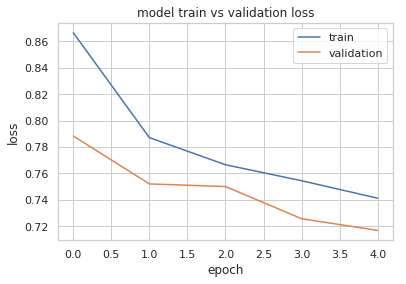

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()